In [37]:
import itertools
import matplotlib.pyplot as plt
import numpy
import pathlib
import random
import torch
import torch.nn
import torch.nn.functional
import tqdm

In [38]:
# Defaults
DIR_READ = pathlib.Path(__name__).resolve().parent
DIR_OUT = pathlib.Path(__name__).resolve().parents[1] / "out" / "makemore-mlp"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
g = torch.Generator(device=device).manual_seed(2147483647) # default seed from the torch docs

In [39]:
# reading data to tokens
def load_txt_to_list(fname):
    path = pathlib.Path(fname)
    if not path.exists():
        raise f"{fname} not found!"

    list_out = []
    with open(path, "r") as file:
        list_out = file.read().splitlines()

    return list_out

def construct_map_token_to_index(list_tokens):
    """
    Returns { token : index }

    Map each token in the vocab to a unique integer,
    which will be its index into the Bag of words vector

    TODO: https://en.wikipedia.org/wiki/Feature_hashing
    NOTE: Fatal flaw is set sorting is random, making debugging a little harder
    """
    dict_to_ix = {}
    dict_to_word = {}
    for i, token in enumerate(set(list_tokens)):
        dict_to_ix[token] = i
        dict_to_word[i] = token

    return dict_to_ix, dict_to_word

fname = DIR_READ / "names.txt"
words = load_txt_to_list(fname)

dict_token_to_ix, dict_ix_to_token = construct_map_token_to_index("".join(words))

list_tokens_extra = ["."]
for token in list_tokens_extra:
    dict_token_to_ix[token] = len(dict_token_to_ix)
    dict_ix_to_token[len(dict_ix_to_token)] = token

In [40]:
# Calculating the ngrams
list_documents = [ list(string) + ["."] for string in words ] # different from before

def construct_vector_ngram(tokens_context, dict_index):
    return list(map(lambda w: dict_index[w], tokens_context))

def construct_n_grams(list_documents, dict_index, size_context, size_prediction=1):
    """
    Initialize an empty window
    Update as you go along

    NOTE: Creates size_context-1 more vectors to account for the stop tokens
    e.g., size_context = 3-1 creates
        [<S>, <S>, <T>]

    TODO: Account for when size_prediction is larger than length(document)
    """
    list_out = []
    vector = [dict_index["."]]*size_context
    for tokens in list_documents:
        # TODO: Right pad tokens to size_prediction
        for i in range(0, len(tokens)):
            vector = vector[size_prediction:] + construct_vector_ngram(tokens[i:i+size_prediction], dict_index)
            list_out.append(vector)
    return list_out

SIZE_CONTEXT = 4 # SIZE_NGRAMS+1 or BLOCKSIZE
list_vectors = construct_n_grams(list_documents, dict_token_to_ix, size_context=SIZE_CONTEXT)
# Verify the mapping
for document in list_documents[:3]:
    for i in range(len(document)): # num_ngrams
        print((["."]*(SIZE_CONTEXT-1) + document)[i:i+SIZE_CONTEXT], list_vectors[i])

matrix_ngrams = torch.tensor(list_vectors, dtype = torch.int64, device=device)

['.', '.', '.', 'e'] [26, 26, 26, 25]
['.', '.', 'e', 'm'] [26, 26, 25, 18]
['.', 'e', 'm', 'm'] [26, 25, 18, 18]
['e', 'm', 'm', 'a'] [25, 18, 18, 7]
['m', 'm', 'a', '.'] [18, 18, 7, 26]
['.', '.', '.', 'o'] [26, 26, 26, 25]
['.', '.', 'o', 'l'] [26, 26, 25, 18]
['.', 'o', 'l', 'i'] [26, 25, 18, 18]
['o', 'l', 'i', 'v'] [25, 18, 18, 7]
['l', 'i', 'v', 'i'] [18, 18, 7, 26]
['i', 'v', 'i', 'a'] [18, 7, 26, 15]
['v', 'i', 'a', '.'] [7, 26, 15, 21]
['.', '.', '.', 'a'] [26, 26, 26, 25]
['.', '.', 'a', 'v'] [26, 26, 25, 18]
['.', 'a', 'v', 'a'] [26, 25, 18, 18]
['a', 'v', 'a', '.'] [25, 18, 18, 7]


In [41]:
# Train/Test Split
random.seed(42)
random.shuffle(matrix_ngrams.clone())
xs = matrix_ngrams[:,0:SIZE_CONTEXT-1]
ys = matrix_ngrams[:,-1] # vector

n1 = int(0.8 * xs.shape[0])
n2 = int(0.9 * xs.shape[0])
Xtr, Xdev, Xts = xs.tensor_split((n1, n2), dim=0)
Ytr, Ydev, Yts = ys.tensor_split((n1, n2), dim=0)

In [42]:
# Same as in the video - before hypertuning to just demonstrate
SIZE_CONTEXT = 4
SIZE_DIMENSION=10
SIZE_HIDDEN=200
NUM_BATCH=32

In [89]:
def train_model(instance_model, num_epochs, dataloader):
    """
    Training loop has been modified such that the epochs are the number of times
        we pass over the entire sampled dataset based on the dataloader

    https://web.stanford.edu/~nanbhas/blog/forward-hooks-pytorch/

    Use hooks to save the self.activation's values and gradients each time it's called
        for the linear layer and each hidden layer
    """
    LEARNING_RATE = 0.1 # discovered empirocally
    optimizer = torch.optim.SGD(instance_model.parameters(), lr=LEARNING_RATE)
    loss_function = torch.nn.CrossEntropyLoss()

    list_loss = []
    # tensor_losses = torch.zeros(size=(num_epochs, len(Xtr)))
    epoch_decay = num_epochs*0.9
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[epoch_decay], gamma=0.1)

    # Hooks to store the activations
    dict_activations = {}
    def get_activation(name):
        # the hook signature
        def hook(model, input, output):
            dict_activations.setdefault(name, [])
            dict_activations[name].append(output.detach())
        return hook

    dict_gradients = {}
    def get_gradient(name):
        # the hook signature
        def hook(module, grad_input, grad_output):
            dict_gradients.setdefault(name, [])
            dict_gradients[name].append(grad_output[0])
        return hook

    # register forward hooks on the layers of choice
    h1 = instance_model.activation.register_forward_hook(get_activation('activation'))
    b1 = instance_model.activation.register_full_backward_hook(get_gradient('activation'))
    dict_out = {
        "activations": [],
        "gradients": []
    }

    for i in tqdm.tqdm(range(num_epochs), total = num_epochs//1000):
        for batch in dataloader:
            instance_model.zero_grad() # zero out the gradients
            xtr, ytr = batch
            log_probs = instance_model(xtr)
            loss = loss_function(log_probs, ytr)

            loss.backward() # compute gradient
            optimizer.step() # update parameters

            list_loss.append(loss.log10().item())
            dict_out["activations"].append(dict_activations['activation'])
            dict_out["gradients"].append(dict_gradients['activation'])

            # detach the hooks to only save after the first run
            h1.remove()
            b1.remove()

        if i == epoch_decay:
            print("\tLoss before learning rate decay:", loss.item())
        scheduler.step()

    print("\tLoss after learning rate decay:", loss.item())

    return instance_model, list_loss, dict_out

# def train_model(model, epochs, dataloader):
#     model.train()
#     list_loss = []
#     dict_out = {
#         "activations": [],
#         "gradients": []
#     }
#     criterion = torch.nn.CrossEntropyLoss()
#     LEARNING_RATE = 0.1 # discovered empirocally
#     optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

#     for epoch in range(epochs):
#         for data in dataloader:
#             inputs, targets = data
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
#             loss.backward()
#             optimizer.step()
#             list_loss.append(loss.item())
#         # Log model's snapshot
#         dict_out["activations"].append({name: param.clone() for name, param in model.named_parameters()})
#         dict_out["gradients"].append({name: param.grad.clone() for name, param in model.named_parameters()})

#     return model, list_loss, dict_out

def plot_activation_layer_statistics(list_tensors, saturated_bound = 0.9, tag="Activation"):
    """
    Assumes you stored these tensors using a hook in pytorch
    """
    out = plt.figure()
    plt.title(f'{tag} Histogram for Each Layer')
    plt.xlabel(f'{tag} Value')
    plt.ylabel('Frequency')
    for i, activation in enumerate(list_tensors):
        t = activation
        saturated_percent = (t.abs() > saturated_bound).float().mean().mul_(100).item()
        print(f"{tag} layer {i}: mean {t.mean():0.2f}, std {t.std():0.2f}, saturated: {saturated_percent}%")
        tensors_hist = torch.histogram(t.detach().cpu(), bins=50, density=True)
        plt.plot(tensors_hist.bin_edges[:-1], tensors_hist.hist, label=f'For Layer {i+1}')
    plt.legend()

    return out

# Exercise 1: Initialize Weights to Zero
Train the neural net by initializing all weights and biases to zero. 
1. Verify the network trains but only partially, and achieves a pretty bad final performance.
2. Inspect the gradients and activations to identify the problem, and identify the parts that are training.

NOTE: We use the final fixing_initialization version since it's easier to initialize the parameters

## Setting a baseline
We will calculate the non-zero'd good initialization as a baseline.

In [50]:
class MLP(torch.nn.Module):
    """
    N-hidden layer feed-forward MLP based on Bengagio et. al (2003)
    """
    def __init__(self, num_embeddings, size_dimension, size_input, size_hidden, size_output, bool_zero_weights=False):
        """
        """
        num_layers = 1 # hard-coded
        super(MLP, self).__init__() # override class
        self.C = torch.nn.Embedding(num_embeddings,embedding_dim=size_dimension)
        self.W = torch.nn.Linear(size_input*size_dimension, size_hidden)
        self.hiddens = torch.nn.ModuleList(
            [torch.nn.Linear(size_hidden, size_hidden) for _ in range(num_layers)]
        )
        self.logits = torch.nn.Linear(size_hidden, size_output)
        self.activation = torch.nn.Tanh()

        if bool_zero_weights:
            self.zero_weights()
        else:
            self.init_weights()

    def init_weights(self):
        """
        Avoid the vanishing gradient problem

        Pytorch torch.nn.Linear layers are automatically initialized using a variant of Kaiming (He) initialization.
        Problem is this works poorly with tanh, whose activations benefit more from Xavier (Godot).
        As is, we would run into the vanishing gradient problem if we didn't invoke batch_normalization
        """
        torch.nn.init.xavier_uniform_(self.W.weight)
        torch.nn.init.zeros_(self.W.bias)
        for hidden in self.hiddens:
            torch.nn.init.xavier_uniform_(hidden.weight)
            torch.nn.init.zeros_(hidden.bias)
        torch.nn.init.xavier_uniform_(self.logits.weight)
        torch.nn.init.zeros_(self.logits.bias)

    def zero_weights(self):
        """
        Create the vanishing gradient problem

        ZERO OUT EVERYBODY
        """
        torch.nn.init.zeros_(self.W.weight)
        torch.nn.init.zeros_(self.W.bias)
        for hidden in self.hiddens:
            torch.nn.init.zeros_(hidden.weight)
            torch.nn.init.zeros_(hidden.bias)
        torch.nn.init.zeros_(self.logits.weight)
        torch.nn.init.zeros_(self.logits.bias)

    def forward(self, vector_input):
        """
        Requires vector of (num_ngrams[indices], size_input)
        """
        embed = self.C(vector_input) # (num_ngrams[indices], size_input, size_dimension)
        embed = embed.view(embed.shape[0], -1) # reshape
        layer = self.W(embed) # (size_dimension, size_hidden)
        layer = self.activation(layer)

        for hidden in self.hiddens:
            layer = hidden(layer) # (size_hidden, size_hidden)
            layer = self.activation(layer)

        layer = self.logits(layer) # (size_hidden, size_output)

        return layer

In [90]:
dataset = torch.utils.data.TensorDataset(Xtr, Ytr)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=NUM_BATCH, shuffle=True)

NUM_EPOCHS = int(4) # one per each dataset run

model = MLP(
    num_embeddings=len(dict_ix_to_token),
    size_dimension=SIZE_DIMENSION,
    size_input=SIZE_CONTEXT-1,
    size_hidden=SIZE_HIDDEN,
    size_output=len(dict_ix_to_token),
    bool_zero_weights=False
)
model, list_loss, dict_snapshots = train_model(model, NUM_EPOCHS, dataloader)

4it [00:19,  4.87s/it]

	Loss after learning rate decay: 1.9375355243682861


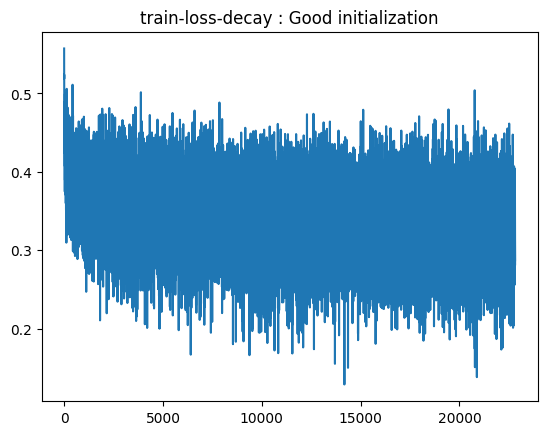

In [91]:
plt.title("train-loss-decay : Good initialization")
plt.plot(list_loss)
plt.show()
plt.close()

Activation layer 0: mean 0.02, std 0.44, saturated: 0.53125%
Activation layer 1: mean -0.03, std 0.38, saturated: 0.15625%
Activation Gradient layer 0: mean 0.02, std 0.44, saturated: 0.53125%
Activation Gradient layer 1: mean -0.03, std 0.38, saturated: 0.15625%


/tmp/ipykernel_55553/1674002297.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  instance_figure.show()
/tmp/ipykernel_55553/1674002297.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  instance_figure.show()


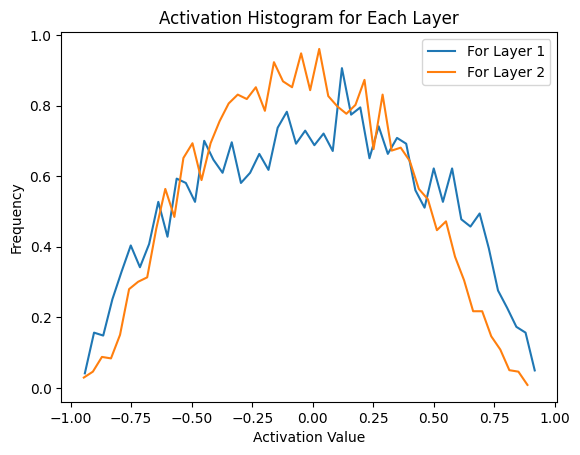

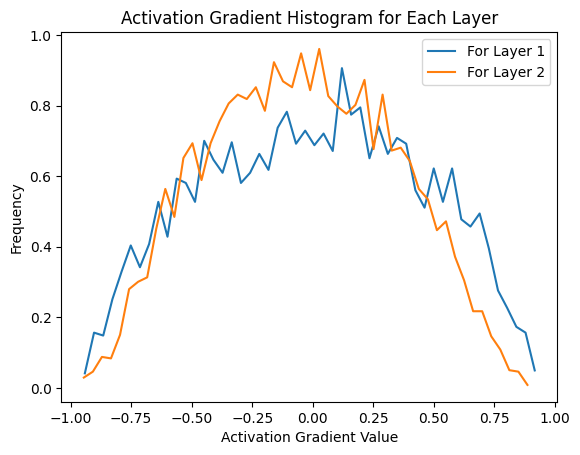

In [92]:
instance_figure = plot_activation_layer_statistics(
    # [i["hiddens.0.weight"] for i in dict_snapshots["activations"]],
    dict_snapshots["activations"][0],
    saturated_bound=0.9,
    tag="Activation"
)
instance_figure.show()

instance_figure = plot_activation_layer_statistics(
    # [i["hiddens.0.weight"] for i in dict_snapshots["gradients"]],
    dict_snapshots["activations"][0],
    saturated_bound=0.9,
    tag="Activation Gradient"
)
instance_figure.show()

In [48]:
# instance_figure = plot_activation_layer_statistics(
#     [i["hiddens.0.bias"] for i in dict_snapshots["activations"]],
#     # dict_snapshots["activations"][0],
#     saturated_bound=0.9,
#     tag="Bias"
# )
# instance_figure.show()

# instance_figure = plot_activation_layer_statistics(
#     [i["hiddens.0.bias"] for i in dict_snapshots["gradients"]],
#     # dict_snapshots["activations"][0],
#     saturated_bound=0.9,
#     tag="Bias Gradient"
# )
# instance_figure.show()

## Verify the partial training
We will compare the network's training loss against non-zero'd initialization, then plot the layer distributions to demonstrate the weights aren't learning anything beyond the first layer.

In [93]:
dataset = torch.utils.data.TensorDataset(Xtr, Ytr)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=NUM_BATCH, shuffle=True)

NUM_EPOCHS = int(4) # one per each dataset run

model_zero = MLP(
    num_embeddings=len(dict_ix_to_token),
    size_dimension=SIZE_DIMENSION,
    size_input=SIZE_CONTEXT-1,
    size_hidden=SIZE_HIDDEN,
    size_output=len(dict_ix_to_token),
    bool_zero_weights=True
)
model_zero, list_loss_zero, dict_snapshots_zero = train_model(model_zero, NUM_EPOCHS, dataloader)

4it [00:19,  4.83s/it]

	Loss after learning rate decay: 2.7376725673675537


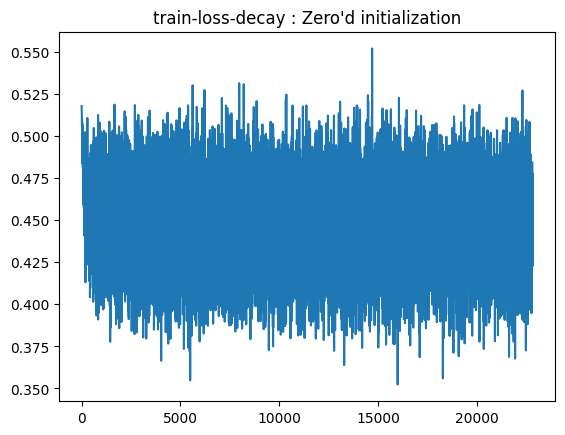

In [94]:
plt.title("train-loss-decay : Zero'd initialization")
plt.plot(list_loss_zero)
plt.show()
plt.close()

Weight layer 0: mean 0.00, std 0.00, saturated: 0.0%
Weight layer 1: mean 0.00, std 0.00, saturated: 0.0%
Weight Gradient layer 0: mean 0.02, std 0.44, saturated: 0.53125%
Weight Gradient layer 1: mean -0.03, std 0.38, saturated: 0.15625%


/tmp/ipykernel_55553/2441622654.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  instance_figure.show()
/tmp/ipykernel_55553/2441622654.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  instance_figure.show()


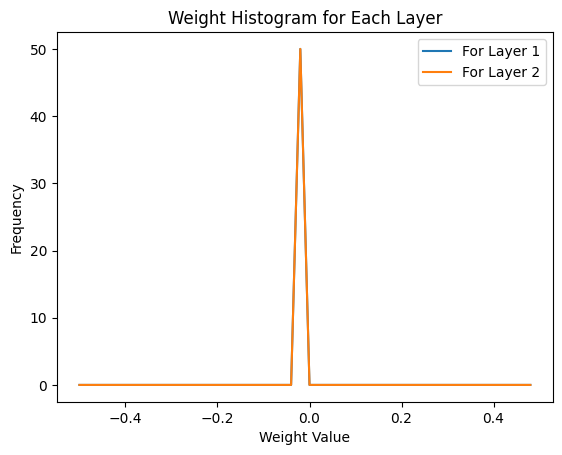

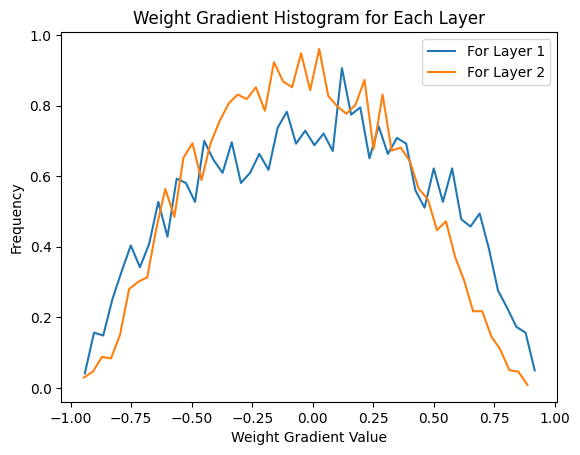

In [95]:
instance_figure = plot_activation_layer_statistics(
    # [i["hiddens.0.weight"] for i in dict_snapshots_zero["activations"]],
    dict_snapshots_zero["activations"][0],
    saturated_bound=0.9,
    tag="Weight"
)
instance_figure.show()

instance_figure = plot_activation_layer_statistics(
    # [i["hiddens.0.weight"] for i in dict_snapshots_zero["gradients"]],
    dict_snapshots["activations"][0],
    saturated_bound=0.9,
    tag="Weight Gradient"
)
instance_figure.show()

In [ ]:
# instance_figure = plot_activation_layer_statistics(
#     [i["hiddens.0.bias"] for i in dict_snapshots_zero["activations"]],
#     # dict_snapshots_zero["activations"][0],
#     saturated_bound=0.9,
#     tag="Bias"
# )
# instance_figure.show()

# instance_figure = plot_activation_layer_statistics(
#     [i["hiddens.0.bias"] for i in dict_snapshots_zero["gradients"]],
#     # dict_snapshots["activations"][0],
#     saturated_bound=0.9,
#     tag="Bias Gradient"
# )
# instance_figure.show()

# Exercise 2: Folding Batchnorm at Inference time

NOTE: After training a neural network that uses batch-normalization, the batchnorm's gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to perform the batch-normalization calculations at inference time. 

Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 via the inverse -- effectivley erasing the batch norm computation. Verify this gives the same forward pass during inference, i.e., we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done!

In [ ]:
def train_model(instance_model, num_epochs, xtr, ytr):
    """
    pytorch is stupid because it doesn't treat (1,N), (N,1) as 1D vectors.
    """
    optimizer = torch.optim.Adam(model.parameters())
    loss_function = torch.nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        instance_model.zero_grad()
        log_probs = instance_model(xtr)
        loss = loss_function(log_probs, ytr.view(-1)) # 'convert' to 1D vector
        loss.backward()
        optimizer.step()
    
    return model

In [ ]:
SIZE_CONTEXT=6
SIZE_OUTPUT=5
NUM_SAMPLES=100
inputs = torch.randn(NUM_SAMPLES,SIZE_CONTEXT, generator=g)
outputs = torch.randint(0, SIZE_OUTPUT, size=(NUM_SAMPLES,1), generator=g)

In [ ]:
class DummyMlpBatchNorm(torch.nn.Module):
    """
    Simple 3-layer MLP with BatchNorm
    """

    def __init__(self, size_input, size_hidden, size_output):
        super(DummyMlpBatchNorm, self).__init__() # override class
        self.linear1 = torch.nn.Linear(size_input, size_hidden)
        self.batchn1 = torch.nn.BatchNorm1d(size_hidden)
        self.linear2 = torch.nn.Linear(size_hidden, size_hidden)
        self.batchn2 = torch.nn.BatchNorm1d(size_hidden)
        self.linear3 = torch.nn.Linear(size_hidden, size_output)
        # self.batchn3 = torch.nn.BatchNorm1d(size_hidden)

    def forward(self, input):
        layer = input
        layer = self.linear1(layer)
        layer = self.batchn1(layer)
        layer = layer.relu()
        layer = self.linear2(layer)
        layer = self.batchn2(layer)
        layer = layer.relu()
        layer = self.linear3(layer)

        return layer

model_bn = DummyMlpBatchNorm(size_input=SIZE_CONTEXT, size_hidden=20, size_output=SIZE_OUTPUT)
model_bn = train_model(model_bn, 10, inputs, outputs)

In [ ]:
def fold_batchnorm(linear, batchnorm):
    """
    Inverse batch-norm to get the W_new, b_new
    """
    gamma = batchnorm.weight 
    beta = batchnorm.bias 
    mean = batchnorm.running_mean 
    var = batchnorm.running_var 
    eps = batchnorm.eps

    # calculate the inverse

    W = linear.weight 
    b = linear.bias

    # calculate W_new, b_new

    return W_new, b_new

class DummyMlp(torch.nn.Module):
    """
    Simple 3-layer MLP
    """
    def __init__(self, size_input, size_hidden, size_output, W1, b1, W2, b2):
        super(MLPWithoutBatchNorm, self).__init__()
        self.linear1 = torch.nn.Linear(size_input, size_hidden)
        self.linear2 = torch.nn.Linear(size_hidden, size_hidden)
        self.linear3 = torch.nn.Linear(size_hidden, size_output)

        self.linear1.weight = nn.Parameter(W1)
        self.linear1.bias = nn.Parameter(b1)
        self.linear2.weight = nn.Parameter(W2)
        self.linear2.bias = nn.Parameter(b2)

    def forward(self, input):
        layer = input
        layer = self.linear1(layer)
        layer = layer.relu()
        layer = self.linear2(layer)
        layer = layer.relu()
        layer = self.linear3(layer)

        return layer

# Create model with folded BatchNorm
W1, b1 = fold_batchnorm(model.fc1, model.bn1)
W2, b2 = fold_batchnorm(model.fc2, model.bn2)
model_no_bn = DummyMlp(size_input=SIZE_CONTEXT, size_hidden=20, size_output=SIZE_OUTPUT, W1=W1, b1=b1, W2=W2, b2=b2)

In [ ]:
# Verify the output is the same
inputs = torch.randn(16, 10)
outputs_with_bn = model_bn(inputs)
outputs_no_bn = model_no_bn(inputs)

print("Outputs with BatchNorm:", outputs_with_bn)
print("Outputs without BatchNorm:", outputs_no_bn)
assert torch.allclose(outputs_with_bn, outputs_no_bn, atol=1e-6), "The outputs are not the same!"

print("BatchNorm successfully folded into the Linear layers.")
